# Photometric Repeatability using `MultiMatch` and `GroupView`

This notebook uses the `MultiMatch` and `GroupView` classes from `afw.table`'s `multiMatch.py`.  It is intended to be run on `lsst-dev.ncsa.illinois.edu`, on an HSC output repository produced at the end of the S15 cycle (where it was used to measure key performance metrics related to photometric repeatability).  It can be adapted to run on other datasets by modifying the repository path and data IDs below.

In [1]:
import numpy
from lsst.afw.table import MultiMatch, SimpleRecord, GroupView
import lsst.daf.persistence

In [2]:
butler = lsst.daf.persistence.Butler("/raid/lauren/rerun/LSST/STRIPE82L/v2/")
dataset = "transformed_src"

In [3]:
schema = butler.get(dataset + "_schema", immediate=True).schema

Create an object that can match multiple catalogs with the same schema

In [4]:
m = MultiMatch(schema, dict(visit=int), RecordClass=SimpleRecord)

Create a list of `DataRef`s for all CCDs images to be included in the plot.

In [5]:
dataRefs = [dataRef for dataRef in butler.subset(dataset, field="STRIPE82L", filter="HSC-I")
            if dataRef.datasetExists(dataset)]

Create visit catalogs by merging those from constituent CCDs.  We also convert from `BaseCatalog` to `SimpleCatalog`, but in the future we'll probably want to have the source transformation tasks generate `SimpleCatalog`s (or `SourceCatalog`s) directly.

In [6]:
byVisit = {}
for dataRef in dataRefs:
    catalog = byVisit.setdefault(dataRef.dataId["visit"], SimpleRecord.Catalog(schema))
    catalog.extend(dataRef.get(dataset, immediate=True), deep=True)

Loop over visits, adding them to the match.

In [7]:
for visit, catalog in byVisit.iteritems():
    m.add(catalog, dict(visit=visit))

Complete the match, returning a catalog that includes all matched sources with object IDs that can be used to group them.

In [8]:
matchCat = m.finish()

Create a mapping object that allows the matches to be manipulated as a mapping of object ID to catalog of sources.

In [9]:
allMatches = GroupView.build(matchCat)

Filter down to matches with at least 5 sources and good flags

In [10]:
flagKeys = [allMatches.schema.find("base_PixelFlags_flag_%s" % flag).key
            for flag in ("saturated", "cr", "bad", "edge")]
nMatchesRequired = 5
def goodFilter(cat):
    if len(cat) < nMatchesRequired:
        return False
    for flagKey in flagKeys:
        if cat.get(flagKey).any():
            return False
    return True
goodMatches = allMatches.where(goodFilter)

In [11]:
psfMagKey = allMatches.schema.find("base_PsfFlux_mag").key
modelMagKey = allMatches.schema.find("base_GaussianFlux_mag").key

In [12]:
from matplotlib import pyplot
%matplotlib inline

Filter further to a limited range in magnitude and extendedness to select bright stars (plotted below)

In [13]:
safeMinMag = 18
safeMaxMag = 19.5
safeMaxExtend = 0.01
def safeFilter(cat):
    psfMag = numpy.mean(cat.get(psfMagKey))
    modelMag = numpy.mean(cat.get(psfMagKey))
    extend = numpy.abs(psfMag - modelMag)
    return psfMag >= safeMinMag and modelMag <= safeMaxMag and extend < safeMaxExtend
safeMatches = goodMatches.where(safeFilter)

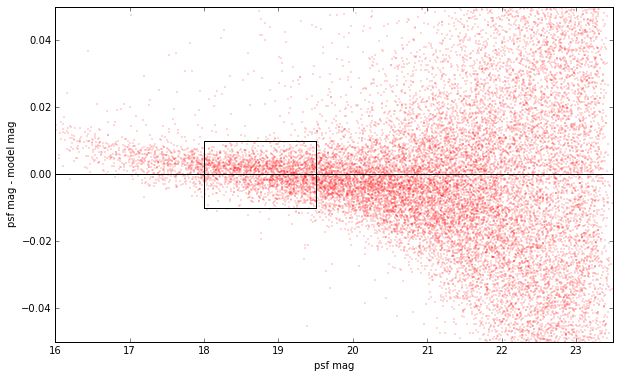

In [14]:
goodPsfMag = goodMatches.aggregate(numpy.mean, field=psfMagKey)
goodModelMag = goodMatches.aggregate(numpy.mean, field=modelMagKey)
fig = pyplot.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.axhline(0, color='k')
ax.scatter(goodModelMag, goodPsfMag - goodModelMag, c='r', s=4, linewidth=0, alpha=0.2)
ax.plot([safeMinMag, safeMaxMag, safeMaxMag, safeMinMag, safeMinMag],
            [-safeMaxExtend, -safeMaxExtend, safeMaxExtend, safeMaxExtend, -safeMaxExtend], 'k-')
ax.set_ylim(-0.05, 0.05)
ax.set_xlim(16, 23.5)
ax.set_ylabel("psf mag - model mag")
ax.set_xlabel("psf mag")

In [15]:
safeMatches = goodMatches.where(safeFilter)

Compute the RMS in two ways: as a direct mean over all differences from the per-object means, and via a mean of the unbiased per-object variance estimates, and plot the differences as scatter and histogram plots, with normal distributions with the two RMS estimates overplotted.

In [16]:
class ClippedVariance(object):
    
    nMeanIterations = 5
    nSigmaIterations = 5
    
    def __init__(self, sigma=None, nSigma=5):
        self.sigma = sigma
        self.nSigma = nSigma
        self.nKept = 0
        self.nTotal = 0
        self.meansTotal = None
        self.meansKept = None
        self.diffsTotal = None
        self.diffsKept = None

    def __call__(self, mag):
        mask = slice(None, None, None)
        nTotal = len(mag)
        if self.sigma is not None:
            nKeptLast = None
            for i in xrange(self.nMeanIterations):
                mu = numpy.mean(mag[mask])
                diff = mag - mu
                mask = numpy.abs(diff) <= self.sigma*self.nSigma
                nKept = mask.sum()
                if nKeptLast is not None and nKeptLast == nKept:
                    break
                elif nKept < nMatchesRequired:
                    return float("NaN")
                nKeptLast = nKept
        else:
            mu = numpy.mean(mag)
            diff = mag - mu
            nKept = nTotal
        if self.meansTotal is not None:
            self.meansTotal[self.nTotal:self.nTotal+nTotal] = mu
            self.meansKept[self.nKept:self.nKept+nKept] = mu
            self.diffsTotal[self.nTotal:self.nTotal+nTotal] = diff
            self.diffsKept[self.nKept:self.nKept+nKept] = diff[mask]
        self.nKept += nKept
        self.nTotal += nTotal
        return numpy.sum((diff[mask])**2)/(nKept - 1)

    def reconstructArrays(self, matches, field):
        self.meansTotal = numpy.zeros(self.nTotal, dtype=float)
        self.meansKept = numpy.zeros(self.nKept, dtype=float)
        self.diffsTotal = numpy.zeros(self.nTotal, dtype=float)
        self.diffsKept = numpy.zeros(self.nKept, dtype=float)
        self.nTotal = 0
        self.nKept = 0
        matches.aggregate(self, field=field)
        return self.meansKept, self.meansTotal, self.diffsKept, self.diffsTotal
    
    @classmethod
    def apply(cls, matches, field, sigma=None, nSigma=5):
        nKept = None
        for i in xrange(cls.nSigmaIterations):
            func = ClippedVariance(sigma=sigma, nSigma=nSigma)
            x = matches.aggregate(func, field=field)
            sigma = numpy.nanmean(x)**0.5
            if nKept is not None and nKept == func.nKept:
                break
            nKept = func.nKept
        meansKept, meansTotal, diffsKept, diffsTotal = func.reconstructArrays(matches, field=field)
        return sigma, meansKept, meansTotal, diffsKept, diffsTotal
            
sigma, meansKept, meansTotal, diffsKept, diffsTotal = ClippedVariance.apply(safeMatches, field=psfMagKey)

(-0.08, 0.08)

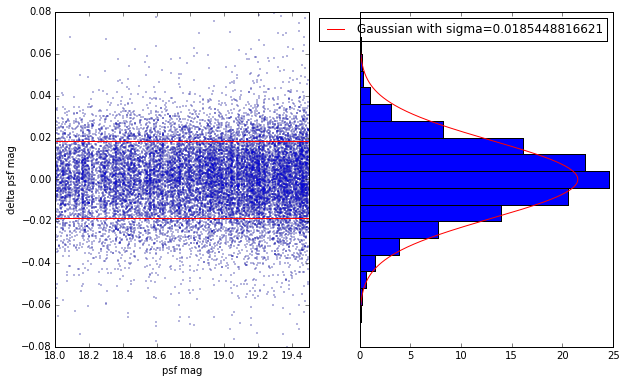

In [17]:
fig = pyplot.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(meansTotal, diffsTotal, c='k', linewidth=0, s=4, alpha=0.2)
ax1.scatter(meansKept, diffsKept, c='b', linewidth=0, s=4, alpha=0.2)
ax1.axhline(sigma, color='r')
ax1.axhline(-sigma, color='r')
ax1.set_xlim(18.0, 19.5)
ax1.set_xlabel("psf mag")
ax1.set_ylabel("delta psf mag")
ax2 = fig.add_subplot(1,2,2, sharey=ax1)
ax2.hist(diffsKept, orientation='horizontal', bins=25, range=(-0.1, 0.1), normed=True)
ax2.get_yaxis().set_visible(False)
y = numpy.linspace(-0.1, 0.1, 1000)
gaussian = numpy.exp(-0.5*(y/sigma)**2)/(sigma*(2.0*numpy.pi)**0.5)
ax2.plot(gaussian, y, 'r-', label="Gaussian with sigma={}".format(sigma))
ax2.legend()
ax2.set_ylim(-0.08, 0.08)

In [18]:
print "RMS = {0:5f} magnitudes, with {1:0.2f}% of measurements clipped as outliers.".format(sigma, 100*(1.0-float(len(diffsKept))/len(diffsTotal)))

RMS = 0.018545 magnitudes, with 0.35% of measurements clipped as outliers.
